# Proyecto Integrador:  American Express - Default Prediction. Predict if a customer will default in the future

Por Juan Antonio Torres Veayra

# Introducción

El objetivo del proyecto consiste en crear un modelo que identifique y cuantifique la posibilidad de que una persona en una ventana de tiempo de 120 días posterior a la generación de su último estado de cuenta no pague su deuda.

Para esto se proporcionada un dataset, donde las variables se encuentran anonimizadas (por lo tanto, no es posible saber que significa cada variable), simplemente se proporciona una guía general donde las variables pueden pertenecer a uno de estos 5 tipos de variables: Delinquency, Spent, Payment, Balance, Risk.

Existe muchos trabajos previos al respecto; por ser un área crítica para la operación bancaria y la importancia del correcto otorgamiento de créditos. En mi experiencia la mayoría de los bancos utilizan software de terceros, como, por ejemplo: SAS Credit Scoring y Moody´s Analytics Credit Risk Scoring. 

Aunque el detalle fino de estos softwares no es público, la mayoría de las soluciones propuestas funcionan del mismo modo: utilizando la metodología y técnicas de Machine Learning. Para ello se construyen diferentes modelos, y se evalúan para seleccionar el ganador. La característica particular de estos modelos es que la distribución de eventos (en este caso default de pago) y no eventos es muy dispareja por lo que se tienen que tener especial cuidado y usar ciertas técnicas para evitar una mala elección de modelo. De manera general, se requiere hacer un pesado para darle mayor prioridad a los eventos y ajustar las métricas de evaluación para que tomen en cuenta esto.

El principal motivo por el cuál elegí este proyecto radica en que actualmente trabajo para el sector bancario, y este caso de uso está completamente relacionada con la principal función de los bancos: identificar posibles usuarios y/o clientes que están en riesgo de default, con métodos lo más precisos posibles ya que la aprobación incorrecta de clientes puede causar grandes pérdidas económicas.

## Desarrollo

### Importar librerías para el proyecto

In [1]:
!pip install kaggle

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing
import os
from sklearn.linear_model import LogisticRegression 
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.naive_bayes import GaussianNB
import random

# Setear los datos de conexión a la API pública de Kaggle
os.environ['KAGGLE_USERNAME'] = 'juantoveayra'
os.environ['KAGGLE_KEY'] = 'XXXXX'
from kaggle.api.kaggle_api_extended import KaggleApi

# Ignorar warnings
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

# Graficar
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

In [34]:
warnings.simplefilter(action='ignore')

### Importar datos desde Kaggle

Autenticar la conexión con Kaggle

In [3]:
api = KaggleApi()
api.authenticate()

Descargar los dataset de la competencia

In [4]:
# 1. Dataset que contiene las etiquetas/labels de los datos de entrenamiento
api.competition_download_file("amex-default-prediction", "train_labels.csv", path="./datasets")
# 2. Dataset que contiene los datos de entrenamiento
api.competition_download_file("amex-default-prediction", "train_data.csv", path="./datasets")

train_labels.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train_data.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


### Cargar datos

Dado que que el dataset de entrenamiento es demasiado grande para cargarlo (>16GB); se aplicará una técnica de muestreo aleatorio con las siguientes consideraron:
* La muestra se realizará sobre CustomerID distintos, esto es para conservar el historial completo de las transacciones de los clientes que se seleccionen durante el proceso de muestreo.
* Se seleccionará el 10% de los clientes.
* Se realizará un muestreo aleatorio.

#### Muestreo aleatorio de Customer_IDs

Leer solamente Customer_IDs

In [5]:
customerIDs = pd.read_csv( './datasets/train_labels.csv.zip',usecols=[0])
print("Total de registros en el dataset(CustomerID únicos):", len(customerIDs))

Total de registros en el dataset(CustomerID únicos): 458913


Obtener la muestra de Customer_ID

In [6]:
customerIDs_sample = customerIDs.sample(frac=0.1, random_state=123)
print("Tamaño de la muestra de customerIDs:", len(customerIDs_sample))

Tamaño de la muestra de customerIDs: 45891


#### Leer datos considerando el muestreo aleatorio

##### Leer "y" (etiquetas) y Filtrar por muestra de Customer_IDs

In [7]:
# Leer labels
y = pd.read_csv('./datasets/train_labels.csv.zip')
y = y.merge(customerIDs_sample)
print("Tamaño de y:", len(y))

Tamaño de y: 45891


##### Leer "X" (datos) y Filtrar por muestra de Customer_IDs

In [8]:
X = pd.DataFrame()

# Filtrar por muestra de Customer_IDs
def filtarCustomerID(chuck, X=X):
    return customerIDs_sample.merge(chunk)

# Leer datos iterando en bloques de 100,000
with pd.read_csv('./datasets/train_data.csv.zip', chunksize=100000) as reader:
    for chunk in reader:
        X = X.append(filtarCustomerID(chunk))
        
print("Tamaño de X:", len(X))

Tamaño de X: 553468


### Preparación de los dataframes X, y

#### Convertir fecha al formato correcto

In [9]:
X['fecha'] = pd.to_datetime(X['S_2'], format='%Y-%m-%d')
X = X.drop(columns=['S_2'])

Visualización inicial de los datos:

In [10]:
X.head()

,customer_ID,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,fecha
0,03a0b3b143501f4be87af0abb525740203bd144d3b76fd...,0.788015,0.008339,0.008258,1.005068,0.005189,0.177269,0.007325,0.011405,NaN,...,NaN,NaN,1.003751,0.007293,0.904780,0.350297,1.004162,0.006111,0.730804,2017-03-12
1,03a0b3b143501f4be87af0abb525740203bd144d3b76fd...,0.820688,0.508056,0.020703,1.009064,0.008859,0.183415,0.000462,0.006284,NaN,...,NaN,NaN,1.004928,0.001155,0.910505,0.356847,1.007794,0.002913,0.734160,2017-04-01
2,03a0b3b143501f4be87af0abb525740203bd144d3b76fd...,0.820640,0.149097,0.050707,1.008181,0.005423,0.246375,0.001700,0.003964,NaN,...,NaN,NaN,1.005148,0.009973,0.909028,0.367084,1.003305,0.001415,0.736878,2017-05-20
3,03a0b3b143501f4be87af0abb525740203bd144d3b76fd...,0.768074,0.272524,0.085200,1.000760,0.007227,0.237148,0.004834,0.002805,NaN,...,NaN,NaN,1.002346,0.001826,0.909474,0.368598,1.007744,0.003986,0.727907,2017-06-23
4,03a0b3b143501f4be87af0abb525740203bd144d3b76fd...,0.766487,0.035309,0.030867,1.005628,0.006025,0.262776,0.006344,0.000273,NaN,...,NaN,NaN,1.007555,0.004746,0.910825,0.366456,1.005809,0.008078,0.734059,2017-07-15


#### Crear un registro único por cliente
Dado que el dataset contiene datos históricos con más de 1 registro por cliente, se creará un dataset de entrenamiento alterno con un registro único por cliente homologando en un solo registro la información de todos los meses. Esto se realizará mediante la transformación de las variables que se encuentran de manera vertical a horizontal. Esto será posteriormente de utilidad para una mejor preparación de los datos y construcción de modelos con técnicas como: imputación de valores vacios, evaluación de modelo que mejor se ajuste a los datos y reducción de variables.

Rankear los meses:

In [11]:
X = X.sort_values(by=['customer_ID','fecha'])
X['rankFecha'] = X.groupby(['customer_ID']).fecha.rank(method='first', ascending=False)

#### Definición de índices de dataframes
Asignar los índices a cada dataframe para facilitar y optimizar el posterior procesamiento

In [12]:
X = X.set_index(["customer_ID"])
y = y.set_index(["customer_ID"])

Iterar para los 13 meses de históricos con los que se cuenta:

In [13]:
X_H = X[X.rankFecha == 1].drop(columns=['fecha', 'rankFecha'])

for i in range(2,14):
    X_H = X_H.join(X[X.rankFecha == i].drop(columns=['fecha', 'rankFecha']), rsuffix="_"+str(i))

Validación de la correcta aplicación del proceso: número de registros total coincide con Customer_ID distintos

In [14]:
print("Total de registros:", len(X_H), "vs Customer_ID distintos:", len(X.index.drop_duplicates()) )
print("Tamaño original del dataset:", len(X))
print("Nuevo tamaño:", len(X_H))

Total de registros: 45891 vs Customer_ID distintos: 45891
Tamaño original del dataset: 553468
Nuevo tamaño: 45891


Asignar el valor de regreso al dataframe X:

In [15]:
X_original = X.copy()
X = X_H

##### Ordenar y para que coincida con el mismo orden de X!!

In [16]:
X = X.sort_index()
y = y.sort_index()

#### Selección de columnas
Revisar los tipos de columnas que tiene el dataset.

In [17]:
tiposDato = pd.DataFrame(X.dtypes, columns=["tipo"])
tiposDato.value_counts()

tipo   
float64    2417
object       26
int64         1
dtype: int64

In [18]:
tiposDato[tiposDato.tipo == 'object']

,tipo
D_63,object
D_64,object
D_63_2,object
D_64_2,object
D_63_3,object
D_64_3,object
D_63_4,object
D_64_4,object
D_63_5,object
D_64_5,object


Dado que solo existen 2 variables categoricas (D_63 y D_64), de momento se dejaran fuera y el esfuerzo principal se hará sobre las variables numéricas

In [19]:
X = X.drop(columns = list(tiposDato[tiposDato.tipo == 'object'].index))

### Visualización de los datos

##### Gráfica de Eventos vs No Evento
Evento - Default de usuario (y=1)
No Evento - No Default de usuario (y=0)

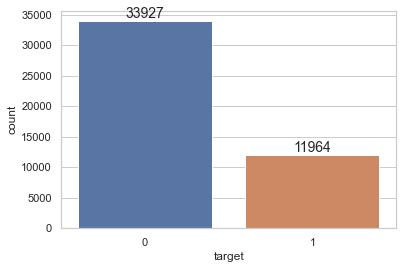

In [20]:
ax = sns.countplot(x=y["target"])
ax.bar_label(ax.containers[0], size = 14)
plt.show()

##### Gráfica de valores nulos

Cálculo de porcentaje de nulos

In [21]:
porciento_nulos = pd.DataFrame({'columna': X.columns, 'p_null': X.isnull().sum() * 100 / len(X)})\
    .sort_values(by='p_null', ascending = False)

Dibujar gráfica

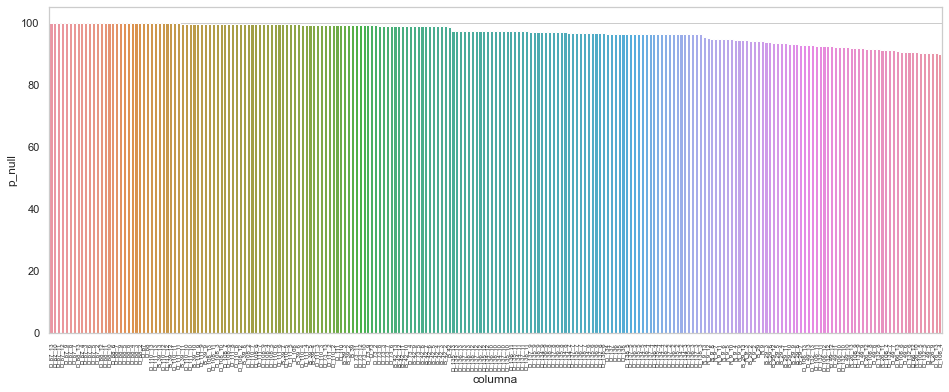

In [22]:
plt.figure(figsize=(16,6))
sns.barplot(data=porciento_nulos[porciento_nulos.p_null > 90], x="columna", y="p_null")
plt.xticks(rotation=90, size= 6)
plt.show()

Existen 231 variables con un % de valores nulos mayor a 90%.
Se removeran estan variables de dataframe:

In [23]:
X = X.drop(columns = list(porciento_nulos[porciento_nulos.p_null > 90].columna))

##### Gráfica de antigüedad
Para casos de aplicación de Machine Learning como Default (dejar de pagar) o Churn (abandono de la compañia) por lo general una variable muy importante es la antiguedad. Por lo que se procederá a realizar un análisis de la misma.

In [24]:
antiguedadClientes = pd.DataFrame(X_original.reset_index().groupby('customer_ID').fecha.count())

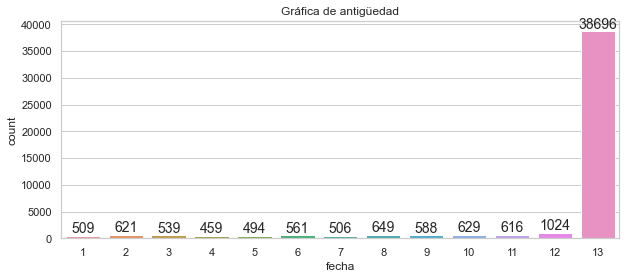

In [25]:
plt.figure(figsize=(10,4))
ax = sns.countplot(x=antiguedadClientes["fecha"], order = antiguedadClientes["fecha"].value_counts().index.sort_values())
ax.bar_label(ax.containers[0], size = 14)
plt.title('Gráfica de antigüedad')
plt.show()

Conclusiones: resulta interesante la gráfica, al verla se puede suponer que los clientes con menos de 13 meses de histórico o son nuevo o abandonaron la compañia (posiblemente en default). Para comprobar esta suposición se realizará la siguiente gráfica de antigüedad vs default.

##### Gráfica de antigüedad vs default

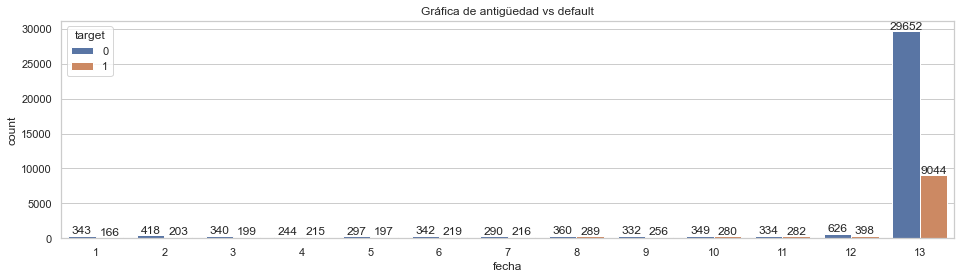

In [26]:
# Join entre y vs antigüedad
antiguedad_vs_default = y.join(antiguedadClientes)

# Gráfica
plt.figure(figsize=(16,4))
ax = sns.countplot(data=antiguedad_vs_default, x="fecha", hue="target", 
                   order = antiguedadClientes["fecha"].value_counts().index.sort_values())
ax.bar_label(ax.containers[0], size = 12)
ax.bar_label(ax.containers[1], size = 12)
plt.title('Gráfica de antigüedad vs default')
plt.show()

##### Gráfica de antigüedad vs default (porcentaje de deafault)

Generar agregado calculando el porcentaje de default por mes

In [27]:
antiguedad_vs_default['valor'] = 1
agg_antiguedad_vs_default = pd.DataFrame(antiguedad_vs_default\
                                         .groupby(['fecha', 'target']).sum().reset_index().groupby('fecha')\
                                         .apply(lambda x : sum(x.valor*x.target)/sum(x.valor)), 
            columns=['% default por antiguedad'])

Dibujar gráfica

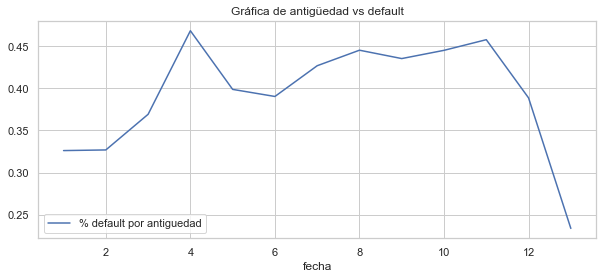

In [28]:
plt.figure(figsize=(10,4))
ax = sns.lineplot(data=agg_antiguedad_vs_default)
plt.title('Gráfica de antigüedad vs default')
plt.show()

#### Conclusión:
Existe un porcentaje más alto de clientes que caen en Default durante los primeros 12 meses. Dado que todos los registros en el dataset contienen fecha de corte a marzo de 2018, se puede asumir que los clientes con menos de 12 meses son clientes nuevos de Amex. Se observa que puede ser una variable nueva muy valiosa para identificar clientes con mayor probabilidad de caer en Default, por lo que se agrega a los datos de entrenamiento.

##### Agregar variable calculada de antigüedad a los dataframe X

In [30]:
antiguedadClientes.columns = ['antiguedad']
X = X.join(antiguedadClientes)

### Tratamiento de Valores Vacios

El primer paso de preparación de los datos para la contrucción de un modelo, será el tratamiento de valores vacios o nulos, para ello se construirá un modelo sencillo de Regresión Logística como modelo base y a partir de ahí se harán modificaciones para tratar de obtener mejores resultados del modelo con distintas técnicas de imputación.

Metodo que se utilizara para validar la calidad de las tecnicas de manero de valores vacíos:

In [31]:
def score_dataset(X, y, model=LogisticRegression()): 
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7,  test_size=0.3, random_state=123)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return accuracy_score(y_test, preds)

#### Eliminar columnas con valores vacios: Modelo base

Técnica a evaluar: eliminar todas las columnas con valores vacios

In [35]:
X_dropcolumns = X.dropna(axis=1)

print("Total de columnas: ",len(X.columns))
print("Total de columnas no vacias: ", len(X_dropcolumns.columns))
accuracy = score_dataset(X_dropcolumns,y)
print("Accuracy:", accuracy)

columnasNoNulas = X_dropcolumns.columns

Total de columnas:  2188
Total de columnas no vacias:  79
Accuracy: 0.8825537478210342


Dataframe de resultados para almacenar resultados:

In [36]:
rTNull = pd.DataFrame()

#### Imputar con media

In [42]:
media_imputer_no_ind = SimpleImputer(strategy='mean', add_indicator = False)
X_meanimputer_no_ind = pd.DataFrame(media_imputer_no_ind.fit_transform(X), 
                                    columns=X.columns)
X_meanimputer_no_ind = X_meanimputer_no_ind.set_index(X.index) # Setear index de nuevo

print("IMPUTACION CON MEDIA SIN INDICADORES DE IMPUTACION:")
accuracy = score_dataset(X_meanimputer_no_ind,y)
print("Accuracy:", accuracy)

# Validar el Accuracy para un modelo para cada columna
for column in X_meanimputer_no_ind.columns:
    
    if column not in columnasNoNulas:
        # Construir modelo de 1 variable
        accuracy = score_dataset(X_meanimputer_no_ind[[column]],y)
        # Guardar resultado
        rTNull = rTNull.append({"Tecnica": 'Imputar con media', "Columna":column, "Accuracy": accuracy}, ignore_index=True)

IMPUTACION CON MEDIA SIN INDICADORES DE IMPUTACION:
Accuracy: 0.8943201626961069


#### Imputar con mediana

In [43]:
mediana_imputer_no_ind = SimpleImputer(strategy='median', add_indicator = False)
X_imp_median_no_ind = pd.DataFrame(mediana_imputer_no_ind.fit_transform(X), 
                                   columns=X.columns)
X_imp_median_no_ind = X_imp_median_no_ind.set_index(X.index) # Setear index de nuevo

print("IMPUTACION CON MEDIANA SIN INDICADORES DE IMPUTACION:")
accuracy = score_dataset(X_imp_median_no_ind,y)
print("Accuracy:", accuracy)

# Validar el Accuracy para un modelo para cada columna
for column in X_imp_median_no_ind.columns:
    
    if column not in columnasNoNulas:
        # Construir modelo de 1 variable
        accuracy = score_dataset(X_imp_median_no_ind[[column]],y)
        # Guardar resultado
        rTNull = rTNull.append({"Tecnica": 'Imputar con mediana', "Columna":column, "Accuracy": accuracy}, ignore_index=True)

IMPUTACION CON MEDIANA SIN INDICADORES DE IMPUTACION:
Accuracy: 0.893739105171412


#### Imputar con valor = 0

In [44]:
valor_imputer = SimpleImputer(strategy='constant', fill_value = 0, add_indicator = False)
X_imp_valor = pd.DataFrame(valor_imputer.fit_transform(X), 
                                   columns=X.columns)
X_imp_valor = X_imp_valor.set_index(X.index) # Setear index de nuevo

print("IMPUTACION CON VALOR=0 SIN INDICADORES DE IMPUTACION:")
accuracy = score_dataset(X_imp_valor,y)
print("Accuracy:", accuracy)

# Validar el Accuracy para un modelo para cada columna
for column in X_imp_valor.columns:
    
    if column not in columnasNoNulas:
        # Construir modelo de 1 variable
        accuracy = score_dataset(X_imp_valor[[column]],y)
        # Guardar resultado
        rTNull = rTNull.append({"Tecnica": 'Imputar con valor = 0', "Columna":column, "Accuracy": accuracy}, ignore_index=True)

IMPUTACION CON VALOR=0 SIN INDICADORES DE IMPUTACION:
Accuracy: 0.8940296339337594


##### Selección de mejor técnica para imputar
Rankear las técicas aplicadas de acuerdo a la que mejor Accuracy tuvo:

In [45]:
rTNull = rTNull.sort_values(by=['Columna','Accuracy'])
rTNull['rankeo'] = rTNull.groupby(['Columna']).Acurracy.rank(method='first', ascending=False)

Seleccionar la técnica con mayor Accuracy

In [46]:
rTNull = rTNull[rTNull.rankeo == 1]
rTNull

,Tecnica,Columna,Acurracy,Accuracy,rankeo
1471,Imputar con media,B_10_10,0.736781,NaN,1.0
1638,Imputar con media,B_10_11,0.736781,NaN,1.0
1805,Imputar con media,B_10_12,0.736781,NaN,1.0
1971,Imputar con media,B_10_13,0.736781,NaN,1.0
2230,Imputar con mediana,B_10_2,0.744698,NaN,1.0
...,...,...,...,...,...
647,Imputar con media,S_9_5,0.736854,NaN,1.0
2924,Imputar con mediana,S_9_6,0.736781,NaN,1.0
3092,Imputar con mediana,S_9_7,0.736854,NaN,1.0
3260,Imputar con mediana,S_9_8,0.736781,NaN,1.0


#### Aplicar imputación a cada columna dependiendo de la selección de técnica del paso anterior

In [47]:
X_imp = X.copy()

# Para cada columna
for i, row in rTNull.iterrows():
    if row.Tecnica == "Imputar con media":
        X_imp[row.Columna] = X_meanimputer_no_ind[row.Columna]
    elif row.Tecnica == "Imputar con mediana":
        X_imp[row.Columna] = X_imp_median_no_ind[row.Columna]
    elif row.Tecnica == "Imputar con valor = 0":
        X_imp[row.Columna] = X_imp_valor[row.Columna]

In [54]:
accuracy = score_dataset(X_imp,y)
print("Accuracy:", accuracy)

Accuracy: 0.893158047646717


## Mutual Information

El cálculo de mutual information ayuda a identificar las variables con mayor potencial para la construcción del modelo de predicción. El valor de Mutual Information sirve para medir la relación entre 2 cantidades o valores; en este caso se utilizará para medir la relación entre cada una de las variables y la variable objetivo. La ventaja de este método con respecto a medir la correlación es que la correlación solo identifica relaciones lineales mientras que esta técnica identifica todo tipo de relación.

In [49]:
def make_mi_scores(X, y):
    X = X.copy()
    mi_scores = mutual_info_classif(X, y, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

Cálculo de mutual information:

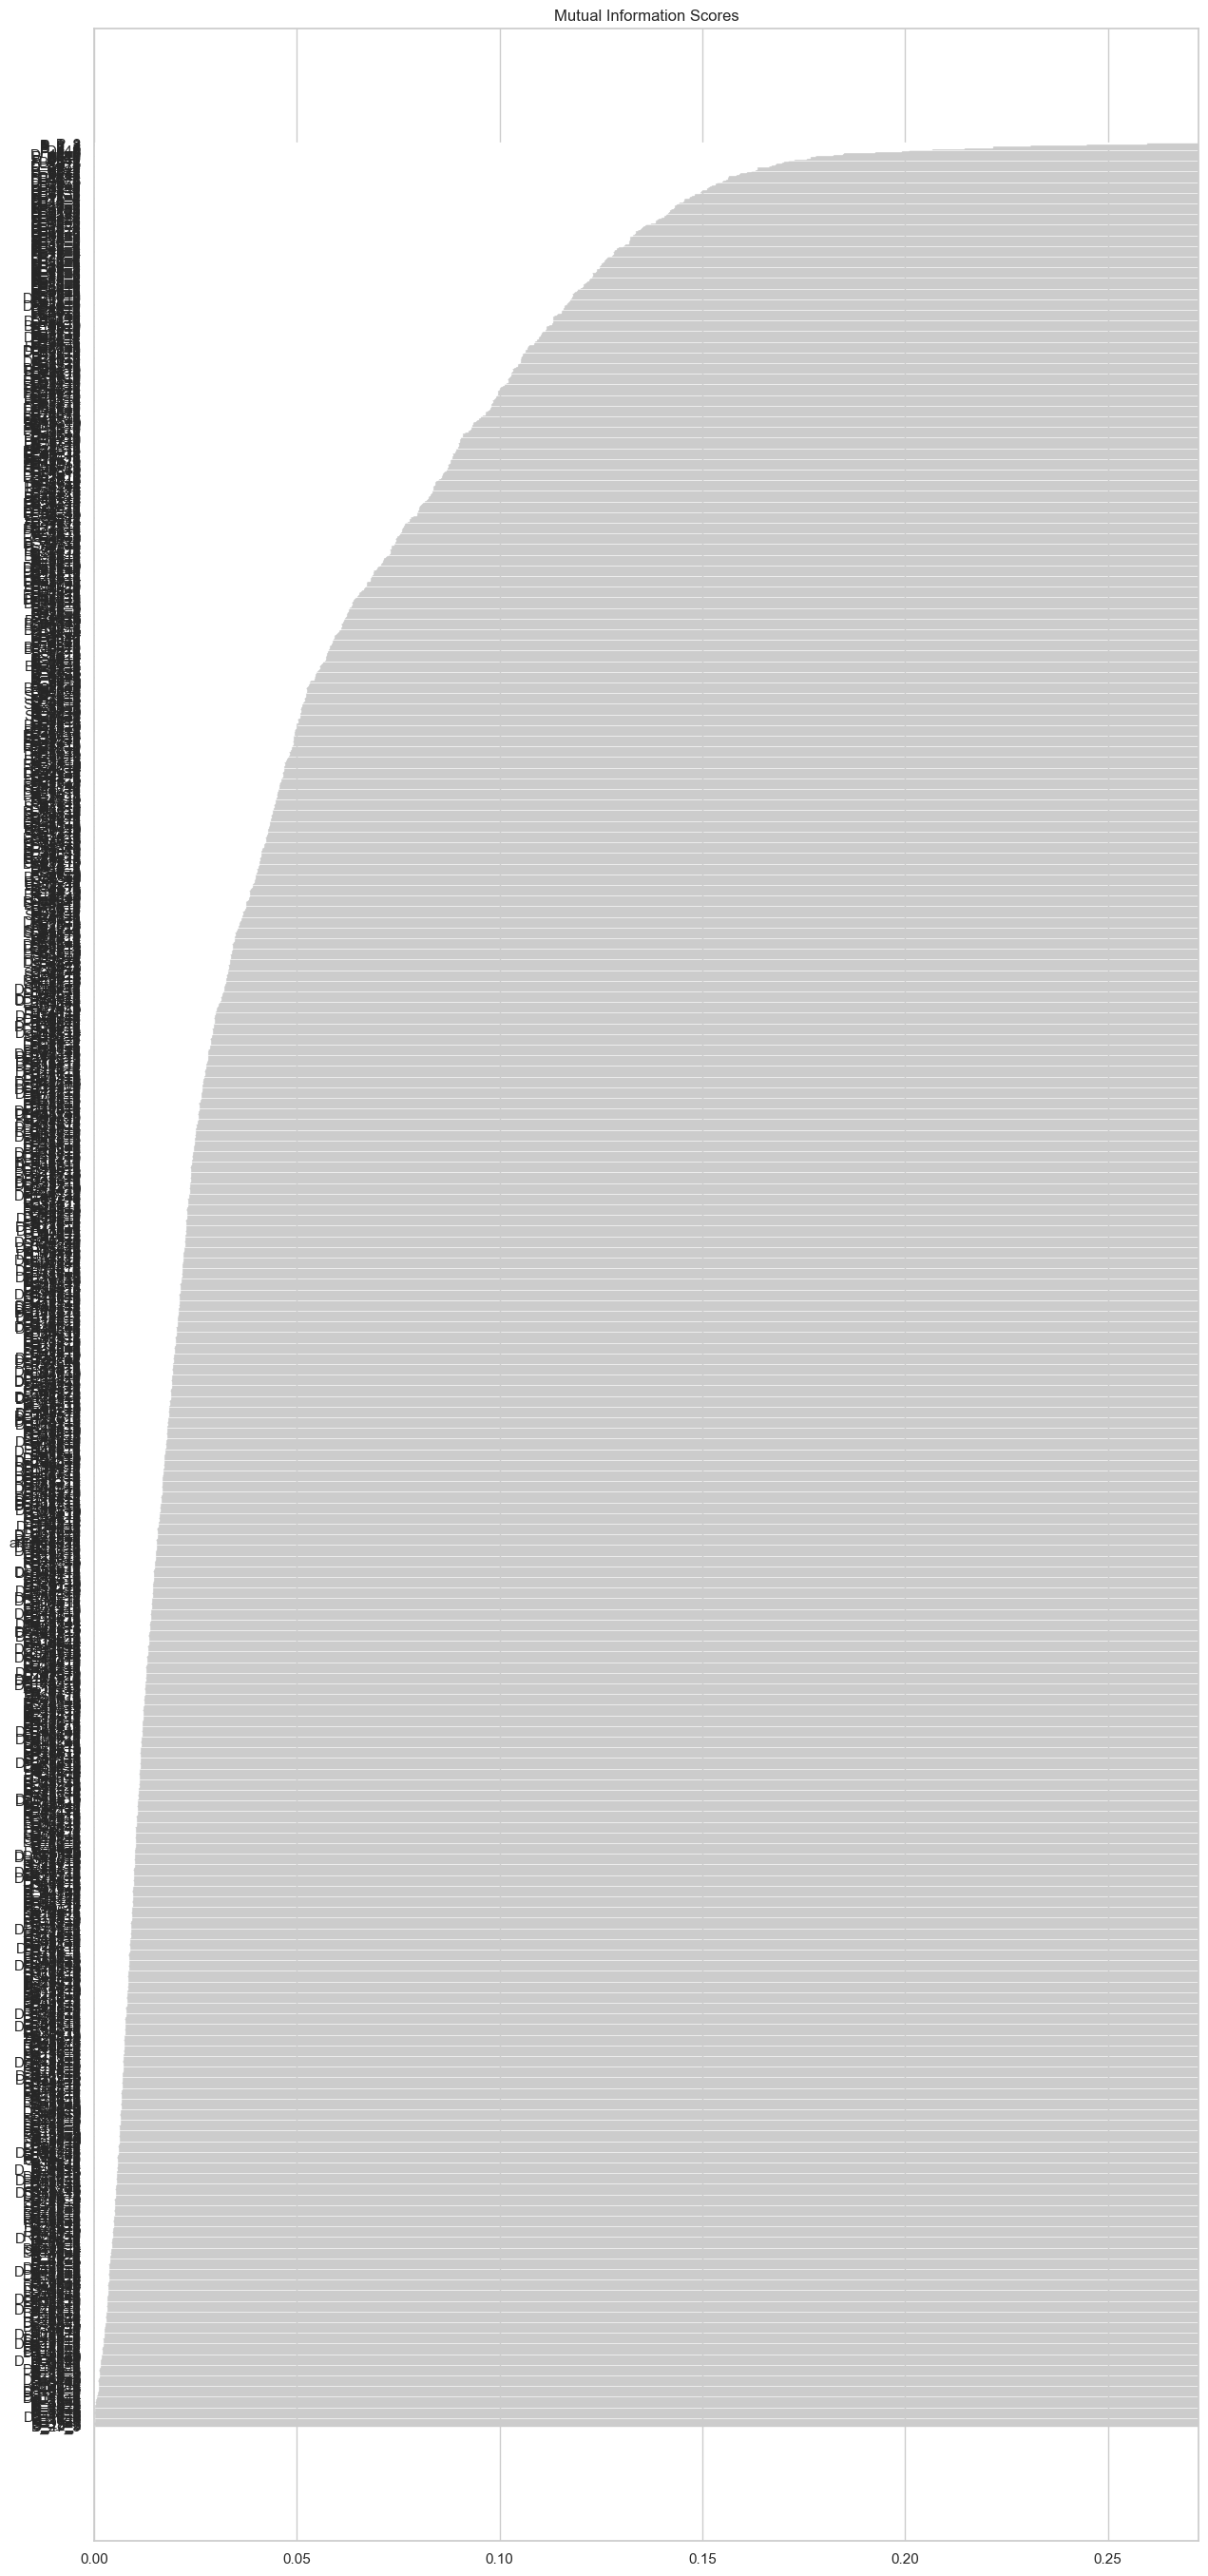

In [50]:
mi_scores = make_mi_scores(X_imp, y.target)

# Graficar resultado
plt.figure(dpi=100, figsize=(15, 35))
plot_mi_scores(mi_scores)

##### Gráfica de modelo sencillo de LogisticRegression para el top N variables
A continuación se gráfica el Accuracy del top N de variables para un modelo de regresión logística. Llama la atención que el mejor modelo posible se obtiene al construir el modelo con el menor número posible de variables. 

In [ ]:
model = LogisticRegression()
resultado_MI = pd.DataFrame()

for i in range(500):
    X_MI = X_imp[list(mi_scores.head(i+1).index)]
    acurracy = score_dataset(X_MI, y, model=model)
    resultado_MI = resultado_MI.append({"i": i, "accuracy": acurracy}, ignore_index=True)
    
# Dibujar gráfica
plt.figure(figsize=(12,4))
ax = sns.lineplot(data=resultado_MI, x="i", y="accuracy")
plt.title('Resultado Mutual Information: Accuracy para Top N variables')
plt.show()

Lo que parece indicarnos la gráfica es que mientras más sencillo y tomando el menor número de variables el modelo se comportaría mejor.

Adicionalmente, el dataset tiene 5 tipos de variables:

D_* = Delinquency variables

S_* = Spend variables

P_* = Payment variables

B_* = Balance variables

R_* = Risk variables

La complejidad adicional de este análisis es que todas las variables son anónimas y nada más podemos saber de manera general el tipo de la variable.

Sin embargo, llama la atención que de las 20 variables con mayor mutual information, 10 son de la **categoría D_* = Delinquency variables y B_* = Balance variables**. Esto nos indica que será necesario poner más atención a estas variables ya que son las que parecen ser más prometedoras.

* Otro de los descubrimientos importantes es que existen variables con MI = 0. Esto nos dice que no tienen ninguna relación con el target; por lo que se quitarán del dataset con el objetivo de reducir el tamaño del mismo.

* Por último, se identificó que la columna de antigüedad tiene un valor de MI bajo, aún y cuando anteriormente se había observado visualmente que tenía potencial para la identificación de eventos de Default.

##### Quitar columnas con MI < 0.01
Para valores muy bajos de Mutual Information se tomó la decisión de remover esas columnas. El límite se estableció en 0.01.

In [55]:
scoresMI = pd.DataFrame(mi_scores).reset_index()
scoresMI

,index,MI Scores
0,P_2,0.259465
1,P_2_2,0.244691
2,P_2_3,0.230879
3,P_2_4,0.221453
4,P_2_5,0.214521
...,...,...
2183,R_22_5,0.000000
2184,S_18,0.000000
2185,D_93_5,0.000000
2186,B_36_5,0.000000


In [59]:
scoresMI = pd.DataFrame(mi_scores).reset_index()
X_MI = X_imp.drop( columns = list(scoresMI[scoresMI["MI Scores"] < 0.01]["index"]) )

# PCA

Dada la cantidad tan grande de features con las que cuenta este dataset, se evaluará a continuación la posibilidad de reducir la dimensionalidad y simultáneamente construir nuevas features mediante la utilización de la técnica de PCA:

Para obtener mejores resultados en PCA es necesario estandarizar:

In [60]:
scaler = StandardScaler()
X_std = pd.DataFrame(scaler.fit_transform(X_MI), columns=X_MI.columns)

Aplicar PCA:

In [61]:
pca = PCA()
X_pca = pca.fit_transform(X_std)
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

Graficar la varianza acumulado:

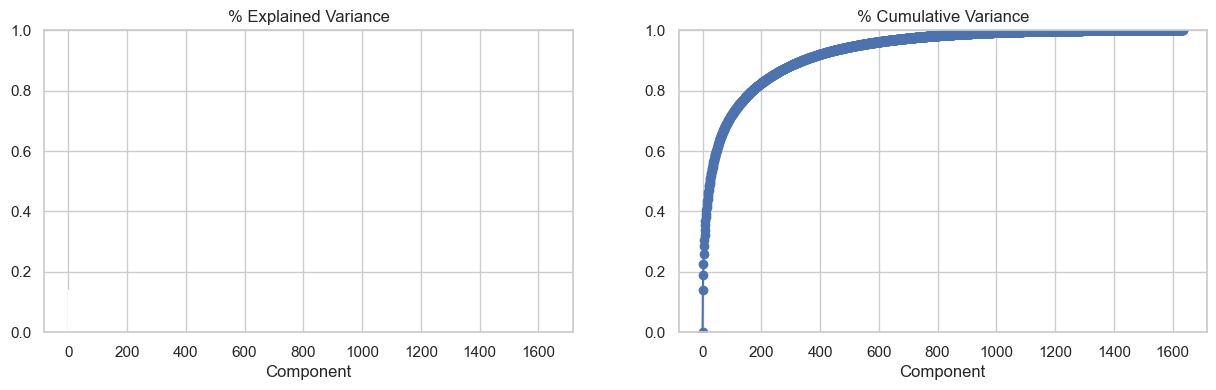

In [62]:
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=15, dpi=100)
    return axs

# Graficar la varianza acumulado
plot_variance(pca)
plt.show()

A continuación se grafican los primeros 500 modelos de componentes principales con el objetivo de identificar cuantos componentes podrían resultar interesantes para la construcción de un modelo.

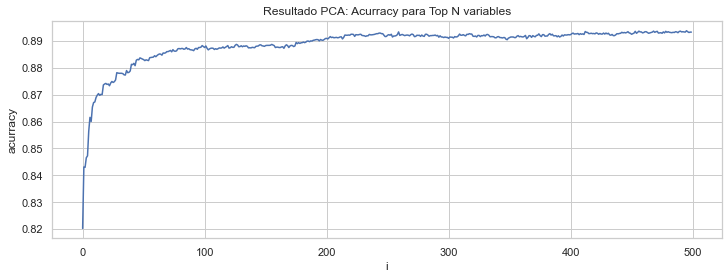

In [63]:
model = LogisticRegression()
resultado_PCA = pd.DataFrame()

for i in range(500):
    acurracy = score_dataset(X_pca.iloc[:,:i+1], y, model=model)
    resultado_PCA = resultado_PCA.append({"i": i, "acurracy": acurracy}, ignore_index=True)
    
# Dibujar gráfica
plt.figure(figsize=(12,4))
ax = sns.lineplot(data=resultado_PCA, x="i", y="acurracy")
plt.title('Resultado PCA: Acurracy para Top N variables')
plt.show()

En la gráfica se observa que a partir de aproximadamente 100 componente el valor de accuracy prácticamente no mejora.

## Seleccionar modelo con mejor desempeño

El paso final consite en aplicación y selección del modelo que mejores resultados otorgue. Dado el tamaño de los datos y las limitantes en capacidad de cómputo, únicamente se entrenará los datos con modelos relativamente "sencillos" dejando de lado otros más complejos como lo son "RandomForest" o "XGBoost".

### Regression Logística

In [ ]:
accuracy = score_dataset(X_MI, y, model = LogisticRegression())
print('Accuracy:', accuracy)

### Árbol de decisiones

In [ ]:
clf = tree.DecisionTreeClassifier()
accuracy = score_dataset(X_MI, y, model = clf)
print('Accuracy:', accuracy)

### Naive-Bayes

In [ ]:
gnb = GaussianNB()
score_dataset(X_MI, y, model = gnb)
print('Accuracy:', accuracy)

### Regression Logística : sobre componentes principales de PCA

Se seleccionan los primeros 100 componentes de PCA, ya que como se observa en la gráfica anterior, a partir de aprox. 100 componentes ya no se obtiene un incremento sustancial en el desempeño del modelo.

In [ ]:
numero_componentes = 100
accuracy = score_dataset(X_pca.iloc[:,:numero_componentes+1], y, model = LogisticRegression())
print('Accuracy:', accuracy)

### Árbol de decisiones : sobre componentes principales de PCA

Se seleccionan los primeros 100 componentes de PCA, ya que como se observa en la gráfica anterior, a partir de aprox. 100 componentes ya no se obtiene un incremento sustancial en el desempeño del modelo.

In [ ]:
numero_componentes = 100
clf = tree.DecisionTreeClassifier()
accuracy = score_dataset(X_pca.iloc[:,:numero_componentes+1], y, model = clf)
print('Accuracy:', accuracy)

### Naive-Bayes : sobre componentes principales de PCA

Se seleccionan los primeros 100 componentes de PCA, ya que como se observa en la gráfica anterior, a partir de aprox. 100 componentes ya no se obtiene un incremento sustancial en el desempeño del modelo.

In [ ]:
numero_componentes = 100
gnb = GaussianNB()
score_dataset(X_pca.iloc[:,:numero_componentes+1], y, model = gnb)
print('Accuracy:', accuracy)

# Conclusión

La construcción de este modelo tuvo varios aspectos complejos, sin embargo, el de mayor complejidad resulto ser como procesar tamaños de información tan grandes; el dataset de entranamiento pesaba más de 16GB por lo que resulta prácticamente imposible trabajarlo en una máquina local, aún y realizando una muestra de los datos el proceso resulto bastante lento.

Por la parte de la construcción del modelo, un reto adicional fue que los datos eran completamente anónimos, no sabiendo siquiera que significaba cada una de las variables proporcionadas. Esto trae consigo un reto mayor ya que únicamente se puede extraer conocimento de los datos sin que entre ej juego algún conocimiento de la insdustria (lo que en muchos casos de Ciencia de Datos resulta crucial).